# Model: Random Forest Classifier (Starter Notebook)

## Objective:
Our goal is to predict the **road condition type** based on the vehicle sensor readings.
Specifically, we are interested in classifying whether the vehicle is on:
- Asphalt
- Cobblestone
- Dirt Road

We will be using the **cleaned dataset** prepared from `01_data_cleaning.ipynb`.

## Dataset:
- Path: `dataset/cleaned_master_dataset.csv`
- Shape: 1,080,905 rows, 81 columns (after cleaning)

## Tasks Overview:
- Load the cleaned dataset
- Basic data exploration (optional, feel free to plot if needed)
- Select key features for training
- Train **Random Forest Classifier**
- Evaluate performance (Accuracy, Confusion Matrix, etc.)

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the cleaned master dataset
df = pd.read_csv('/content/cleaned_master_dataset.csv')

# Quick check
print(df.shape)
print(df.head())

(1080905, 81)
      timestamp  acc_x_dashboard_left  acc_y_dashboard_left  \
0  1.577219e+09              0.365116              0.167893   
1  1.577219e+09              0.392649              0.176273   
2  1.577219e+09              0.409408              0.181062   
3  1.577219e+09              0.371101              0.164302   
4  1.577219e+09              0.390255              0.159514   

   acc_z_dashboard_left  acc_x_above_suspension_left  \
0              9.793961                     0.327626   
1              9.771216                     0.381496   
2              9.732909                     0.283333   
3              9.749668                     0.314458   
4              9.869378                     0.344385   

   acc_y_above_suspension_left  acc_z_above_suspension_left  \
0                     0.172733                     9.781861   
1                     0.189492                     9.699261   
2                     0.182310                     9.807000   
3                 

In [3]:
# Identify and remove rows with NaN values in 'dirt_road'
print(f"Number of NaNs before dropping: {df['dirt_road'].isnull().sum()}")
df = df.dropna(subset=['dirt_road'])
print(f"Number of NaNs after dropping: {df['dirt_road'].isnull().sum()}")

Number of NaNs before dropping: 0
Number of NaNs after dropping: 0


## Some EDA here

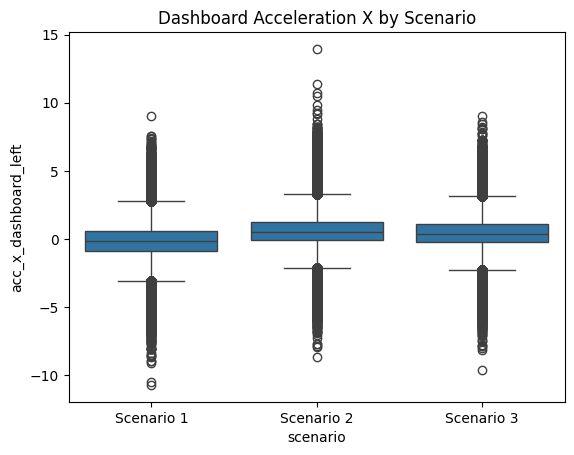

In [4]:
# Ex: Quick EDA - Visualize vibration data or vehicle-specific trends
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='scenario', y='acc_x_dashboard_left', data=df)
plt.title('Dashboard Acceleration X by Scenario')
plt.show()

In [5]:
# Example Feature Selection (This will depend on their work later)
features = df[['acc_x_dashboard_left', 'acc_y_dashboard_left', 'acc_z_dashboard_left']]
target = df['dirt_road']  # Example: Predicting dirt road (0 or 1)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)



Accuracy: 0.7148037986687081
Confusion Matrix:
[[140326  15860]
 [ 45794  14201]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82    156186
           1       0.47      0.24      0.32     59995

    accuracy                           0.71    216181
   macro avg       0.61      0.57      0.57    216181
weighted avg       0.68      0.71      0.68    216181



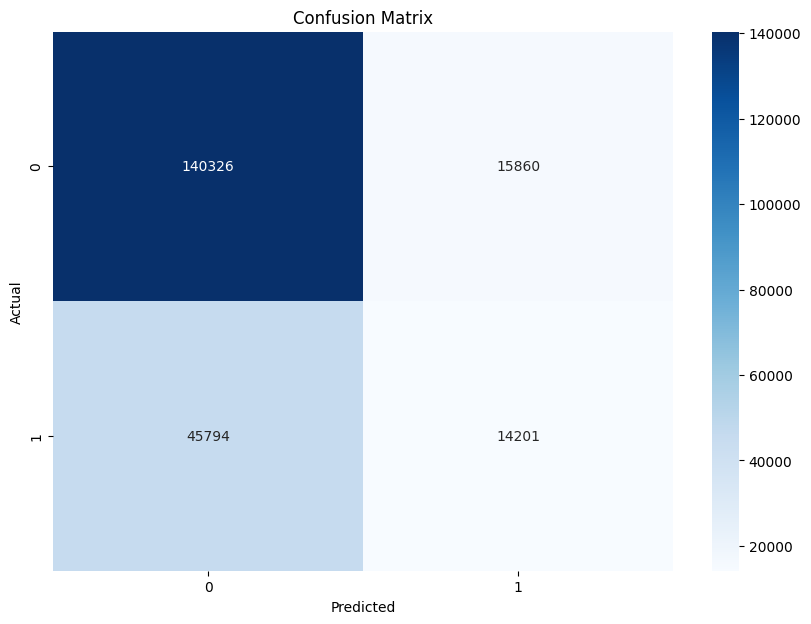

Training Accuracy: 0.9999653068493531
Testing Accuracy: 0.7148037986687081


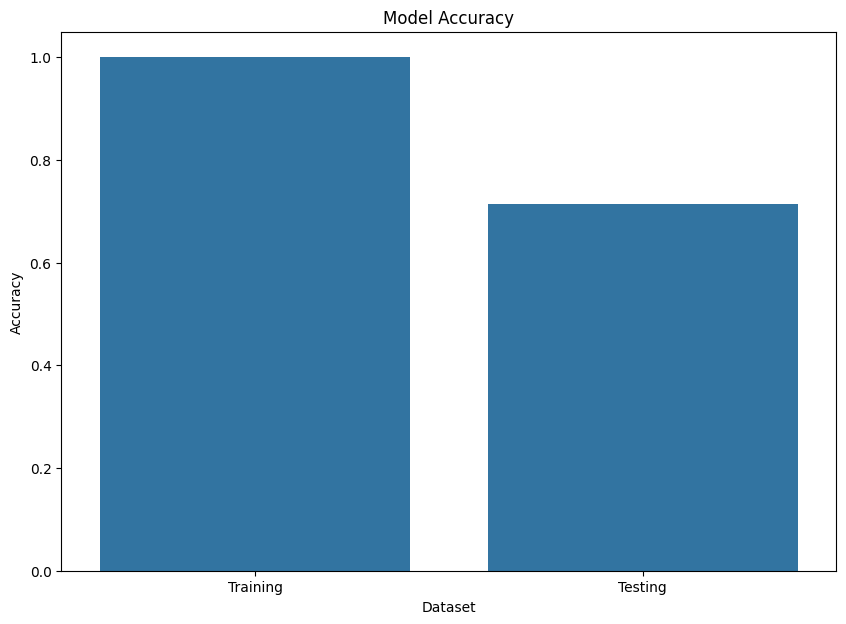

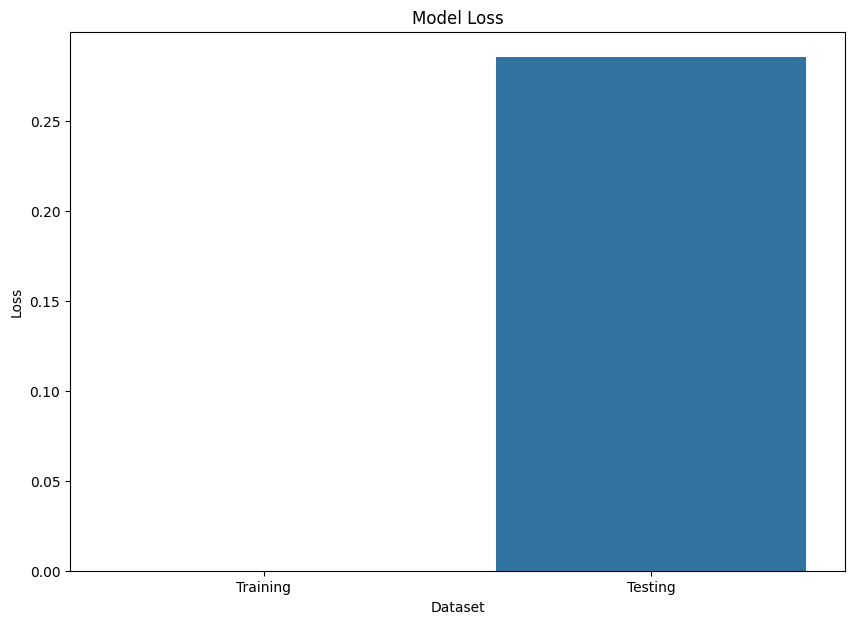

In [6]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Model loss and accuracy
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f'Training Accuracy: {train_accuracy}')
print(f'Testing Accuracy: {test_accuracy}')

# Plot model accuracy using seaborn
accuracy_data = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Accuracy': [train_accuracy, test_accuracy]
})

plt.figure(figsize=(10, 7))
sns.barplot(x='Dataset', y='Accuracy', data=accuracy_data)
plt.title('Model Accuracy')
plt.show()

# Plot model loss using seaborn (assuming loss is 1 - accuracy for simplicity)
loss_data = pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Loss': [1 - train_accuracy, 1 - test_accuracy]
})

plt.figure(figsize=(10, 7))
sns.barplot(x='Dataset', y='Loss', data=loss_data)
plt.title('Model Loss')
plt.show()

In [7]:
# save the model
import pickle

# Save the model to a file
with open('/content/random_forest_model.pkl', 'wb') as f:
    pickle.dump(model, f)
